# Lab 6

In [3]:
import json
import numpy as np
import pickle as pkl
import wikipediaapi as wpa
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### Klasa pobierająca wybrane artykuły z wikipedii

Pobieranie artykułów z wikipedii na podstawie biblioteki wikiepedia-api
Biblioteka pobiera artykuly na podstawie podanej kategorii

Następnie po pobraniu wybranej ilości tworzony jest słownik wszystkich wyrazów oraz
słownik wyrazów dla kazdej poszczególnej strony.
Te dane są zapisywane do odpowiednich plików za pomocą pickle 

In [3]:
class WikipediaPage():
    def __init__(self,max_articles_per_category=100):
        self.sites = set()
        self.wiki = wpa.Wikipedia('en')
        self.words = dict()
        self.dicts = []
        self.site_list = []
        self.wnl = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.max_articles_per_category = max_articles_per_category

    def crawl(self,categorymembers,count,level=0, max_level=1):
        for c in categorymembers.values():
            if c.ns == wpa.Namespace.CATEGORY and level < max_level:
                self.crawl(c.categorymembers,count ,level=level + 1, max_level=max_level)
            elif c.ns == wpa.Namespace.MAIN:
                if len(self.sites) <= self.max_articles_per_category * count:
                    self.sites.add(c)
    def get_words(self,sites):
        for site in sites:
            self.dicts.append(dict())
            content = site.text
            word_list = content.split()
            stemmed = [self.wnl.lemmatize("".join(filter(lambda x: x.isalpha(), word))
                                     ).casefold() for word in word_list]
            for s in stemmed:
                if s not in self.stop_words:
                    self.dicts[-1][s] = self.dicts[-1].get(s, 0) + 1
                    self.words[s] = self.words.get(s, 0) + 1
    def get_wiki_data(self,i):
        categories = ["Physics","Music","Games","Mathematics","Chemistry","Biology","Geography","History","Art","Literature","Philosophy","Politics","Economics","Sociology","Psychology","Religion","Sports","Technology","Engineering","Medicine","Astronomy","Space","Agriculture","Architecture","Business","Education","Environment","Fashion","Food","Law","Military","Transportation","Weather","Culture","Language","Media","Military","Science","Society","Technology","World"]
        print("Downloading categories started")
        count = 0
        for c in categories:
            count += 1
            print(c)
            wiki_name = "Category:" + c
            cat = self.wiki.page(wiki_name)
            self.crawl(cat.categorymembers,count)
            if len(self.sites) > i:
                break
        self.site_list = list(self.sites)[:i]
        with open("content/titles.pkl", "wb") as write_file:
            pkl.dump([site.title for site in self.site_list], write_file)
        print("Downloading categories finished")
        self.get_words(self.site_list)
        print("Downloading sites finished")
        return self.words,self.dicts

### Klasa Matrix

Klasa ta pobiera wszystkie bag-of-words (musimy sobie je pobrać z plików)
Tworzy ona rzadką macierz wektorów cech term-by-document
Następnie przetwarza macierz za pomocą IDF
Normalizuje wektory z macierzy cech
Na koniec przekształca tę macierz za pomoca SVD 


In [4]:
class Matrix():
    def __init__(self,words=None,sites_words=None,n=None):
        self.n = n
        self.words = words
        self.dicts = sites_words
        self.wnl = WordNetLemmatizer()

    def get_matrix(self):
        self.keys = list(self.words.keys())
        self.number_of_words = len(self.keys)
        self.matrix = np.zeros((self.n, self.number_of_words))
        self.index = {i: self.keys[i] for i in range(self.number_of_words)}
        self.reverse_index = {self.keys[i]: i for i in range(self.number_of_words)}
        #Iterate through sites
        for i in range(self.n):
            #Iterate through words
            for word in self.dicts[i]:
                self.matrix[i,self.reverse_index[word]] = self.dicts[i][word]
        print("frequency normalization started")
        #It's inverse document frequency
        m = np.log10(np.array([n / sum(1 for article in self.dicts if self.keys[i] in article) for i in range(self.number_of_words)]))
        self.matrix = self.matrix * m

        #Here starts normalization of vectors
        lengths = np.nan_to_num(1 / np.sqrt(np.sum(self.matrix ** 2, axis=1)), False, nan=0.0, posinf=0.0, neginf=0.0)
        self.matrix = (self.matrix.T * lengths).T
        print("frequency normalization finished")
        #lower approximation
        print("starting lower approximation")
        U, D, V = np.linalg.svd(self.matrix)
        r = len(D)
        print("calculating matrix")
        self.matrix = U[:, :r] @ np.diag(D) @ V[:r, :]
        print("matrix created")

    def save(self):
        with open("content/matrix.pkl", "wb") as write_file:
            pkl.dump(self.matrix, write_file)
        with open("content/dict.pkl", "wb") as write_file:
            pkl.dump(self.index, write_file)



Przykładowe wywołanie funkcji wyszukującej artykuły:

n - ilość artykułów

per_category - ilosc artykułow na kazda kategorie uwzglednioną w klasie WikipediaPage

In [ ]:
n = 100
per_category = 100
Wiki = WikipediaPage(per_category)
words_data, sites_data = Wiki.get_wiki_data(n)

Zapisanie do pliku tych danych

In [5]:
# If you want to write


with open("content/words_data.pkl", "wb") as write_file:
    pkl.dump(words_data, write_file)
with open("content/sites_data.pkl", "wb") as write_file:
    pkl.dump(sites_data, write_file)


Wczytanie ich ponownie

In [ ]:

with open("content/words_data.pkl", "rb") as read_file:
    words_data = pkl.load(read_file)
with open("content/sites_data.pkl", "rb") as read_file:
    sites_data = pkl.load(read_file)

Przykładowe wywołanie klasy Matrix

In [ ]:
n = 100
matrix = Matrix(words_data,sites_data,n)
matrix.get_matrix()
matrix.save()

Na koniec nalezy włączyc program search.py podajac 2 argumenty: nazwa wyszukiwana oraz ilosc artykułów, np:

python3 search.py math 5

Wyświetli nam jsona który zawiera wszystkie artykuły z najlepszym prawdopodobienstwem posortowane malejące według tej wartości

Ponizej wrzucam kod tego pliku:


In [ ]:
import sys
import spacy
import warnings
warnings.filterwarnings("ignore")

def search(top,text):
    wnl = WordNetLemmatizer()
    with open("content/titles.pkl", "rb") as read_file:
        sites = pkl.load(read_file)
    with open("content/dict.pkl", "rb") as read_file:
        indexes = pkl.load(read_file)
    with open("content/matrix.pkl", "rb") as read_file:
        matrix = pkl.load(read_file)

    reverse_index = {indexes[i]:i for i in indexes}

    vector = np.zeros(len(indexes))

    for word in text.split():
        word_lemma = wnl.lemmatize("".join(filter(lambda x: x.isalpha(), word))).casefold()
        if word_lemma in reverse_index:
            index = reverse_index[word_lemma]
            vector[int(index)] += 1
    
    prob = np.abs((vector.T @ matrix.T)) / np.sqrt(np.sum(
            matrix ** 2, axis=1))
    prob = [(prob[i],i) for i in range(len(prob))]
    prob.sort(reverse=True)
    all = prob[:top]
    best = [(sites[i], f"{prob*100:.2f}",get_links(sites[i])) for prob,i in all]
    print(json.dumps({"result": best}))
def get_links(title):
    return "https://en.wikipedia.org/wiki/"+title.replace(" ", "_")

try:
    nlp = spacy.load("en_core_web_sm")
    query = " ".join([token.lemma_ for token in nlp(sys.argv[1])])

    top = int(sys.argv[2])
    search(top,query)
except Exception as e:
    sys.exit(json.dumps({"error": str(e)}))


Oczywiście ta funkcja jest zastosowana w całym programie, aby uruchomić server 

nalezy w folderze głownym najpierw wpisac:

npm install

po zainstalowaniu wszelkich pakietów:

node app.js

Server zacznie nasluchiwac na wskazanym porcie, domyslnie to localhost:3000 


Przykładowy wygląd pobierania artykułow w przegladarce znajduje sie pod zdjeciem example.png

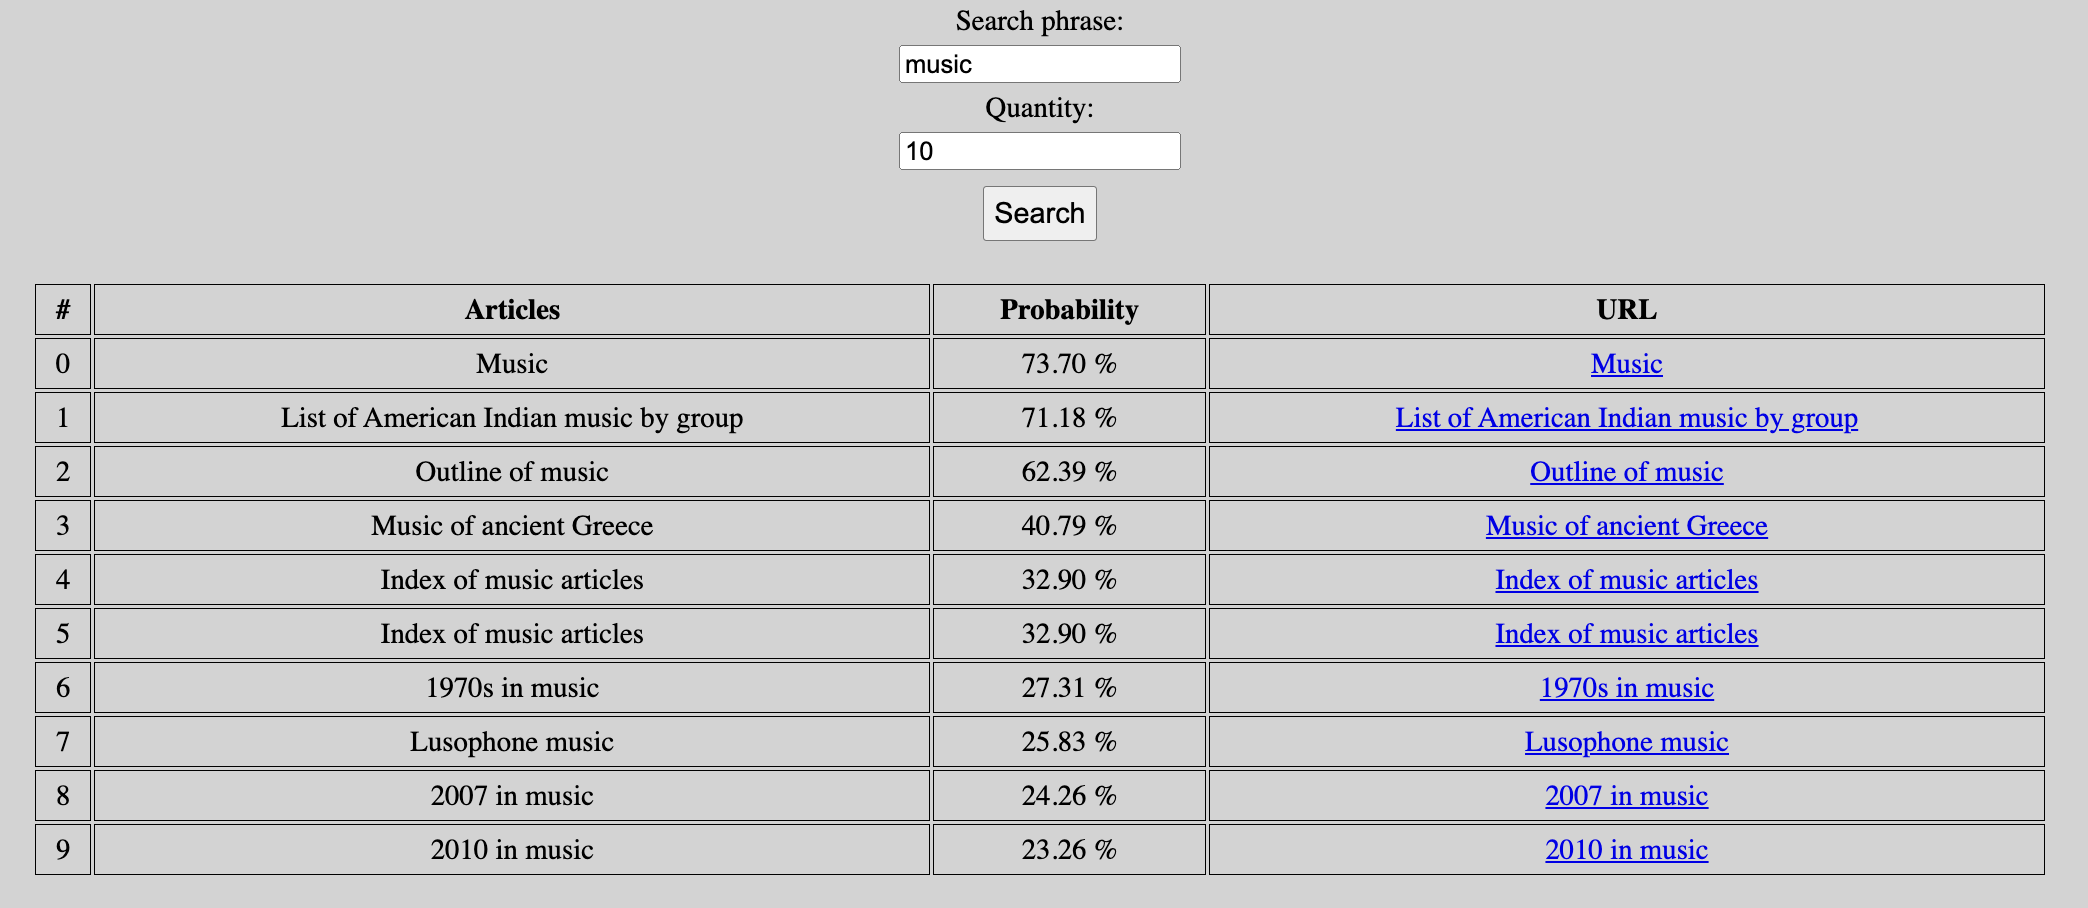

In [7]:
from IPython.display import Image
Image(filename='example.png') 

Program zdaje się działac poprawnie i nie wyświetla błędów, problem sie zaczyna gdy trzeba bardzo duzo wygenerowac artykułów
wtedy tez przydałby sie mocny serwer który bardzo szybko nam wymnozy macierz i ja zapisze, (co jest związane z svd)

Rzeczywiscie mozna zauwazyc ze przy uzyciu svd artykuly sa lepiej wybierane i odrzucane te malo interesujace, ale trzeba
zgadnac te wartosc k oraz miec bardzo mocna maszyne do obliczania macierzy

W zaleznosci od kategorii, najlepsza wartość k zdaje sie oscylować w poblizu liczby 10 jest to zwiazane z iloscia artykułów 

IDF nie mialo wiekszego znaczenia przy wyliczaniu 